<a href="https://colab.research.google.com/github/a-afful/DataScienceProjects/blob/master/HousePrices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project - House Prices: Advanced Regression Techniques**
**Abena Afful**

This data is found on Kaggle.com. The purpose of the project is to see which factor contribute to the final house prices in Ames, Iowa. There are 70 explanatory variables. In this project I will be using regression techniques to determine which feature(s) influences the final residental home prices in Ames.


# **Importing the Data**

The first step in all python programming is to import the necessary libraries that will help compute the regression. I will also import the data labeling the training data and the test data.

In [ ]:
# import the necessary libraries
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import  LinearRegression
import xgboost as xgb

# to download files to computer
from google.colab import files

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# import and loading data into dataframes
train_df = pd.read_csv("https://aafful1-it4ba.s3.amazonaws.com/train.csv")
test_df = pd.read_csv("https://aafful1-it4ba.s3.amazonaws.com/test.csv")

After import the libraries that I need, I will then inspect the data to get familiar with the data I'll be working with. I'll also do this to make sure if there is any missing information, I will address it in the appropiate manner.

In [ ]:
# Get information on training data
train_df.info()
train_df.head()

In [ ]:
# Get information on test data
test_df.info()
test_df.head()

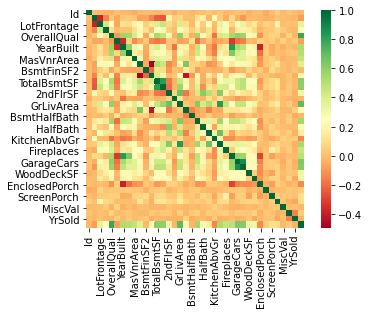

In [ ]:
# using a heatmap to see how the features correlate with the SalePrice
sns.heatmap(train_df.corr(), square=True, cmap='RdYlGn')

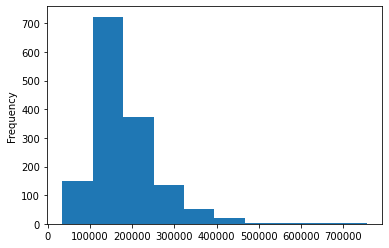

In [ ]:
train_df['SalePrice'].plot.hist()
#From this histogram, we see some outliers towards the higher prices houses

# **Explanatory Data Analysis & Data Cleaning**

This is the section where I'll start cleaning the data and deal with the missing data. I'll use the mean of the categories missing information to fill in.

In [ ]:
# checking for any missing data
train_df.isna().sum()

In [ ]:
test_df.isna().sum()

There seems to be a lot of missing data in LotFrontage, and a few missing in MSZoning, and SaleType. I will fill in those missing information with the average for each category.

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x = train_df['GrLivArea'], y = train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

From this scatter plot we see that GrLivArea has 2 extreme outliers to the right of the graph.

In [ ]:
train_df = train_df.drop(train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice']< 300000)].index)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x = train_df['GrLivArea'], y = train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

I'm also going to check the outlier in LotFrontage

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x = train_df['LotFrontage'], y = train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('LotFrontage', fontsize=13)
plt.show()

This also shows an outlier so I'll remove it as I did with the GrLivArea feature

In [ ]:
train_df = train_df.drop(train_df[(train_df['LotFrontage'] > 300) & (train_df['SalePrice']< 300000)].index)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x = train_df['LotFrontage'], y = train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('LotFrontage', fontsize=13)
plt.show()

Now with most of the important outliers out of the way, I am now going to replace the NaN's, that I mentioned prior. But before that I will combine both the training and test data to make the replacement quicker and easier.

In [ ]:
atrain = train_df.shape[0]
atest = test_df.shape[0]
both_data = pd.concat([train_df, test_df]).reset_index(drop=True)
both_data = both_data.fillna(np.nan)

In [ ]:
# Getting the percentage of the missing data
both_data_nan = (both_data.isnull().sum() / len(both_data)) * 100
both_data_nan = both_data_nan.drop(both_data_nan[both_data_nan == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Data Percentage': both_data_nan})
missing_data.head

With this information, I will now begin filling in the missing data. 

*Note:* Based on the data description some the missing information is due to the home not does features. For example, not all the homes have Pools and that's what leads to them having missing data. I will fill those in with "None" 

In [ ]:
both_data.PoolQC[both_data.PoolQC.isnull() == True] = 'None'
both_data.MiscFeature[both_data.MiscFeature.isnull() == True] = 'None'
both_data.Alley[both_data.Alley.isnull() == True] = 'None'
both_data.Fence[both_data.Fence.isnull() == True] = 'None'
both_data.FireplaceQu[both_data.FireplaceQu.isnull() == True] = 'None'
both_data.GarageCond[both_data.GarageCond.isnull() == True] = 'None'
both_data.GarageQual[both_data.GarageQual.isnull() == True] = 'None'
both_data.GarageFinish[both_data.GarageFinish.isnull() == True] = 'None'
both_data.BsmtExposure[both_data.BsmtExposure.isnull() == True] = 'None'
both_data.BsmtCond[both_data.BsmtCond.isnull() == True] = 'None'
both_data.BsmtQual[both_data.BsmtQual.isnull() == True] = 'None'
both_data.BsmtFinType2[both_data.BsmtFinType2.isnull() == True] = 'None'
both_data.BsmtFinType1[both_data.BsmtFinType1.isnull() == True] = 'None'
both_data.GarageType[both_data.GarageType.isnull() == True] = 'None'
both_data.MasVnrType[both_data.MasVnrType.isnull() == True] = 'None'

Filling in the numerical missing data with zeros(if the house doesn't have the feature), medians, modes, and means in those categories.

In [ ]:
both_data['LotFrontage'] = both_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [ ]:
# Filling in the homes that did not have certain features with 0
for column in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
  both_data[column] = both_data[column].fillna(0)

In [ ]:
for column in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    both_data[column] = both_data[column].fillna(0)

In [ ]:
both_data['MasVnrArea'] = both_data['MasVnrArea'].fillna(0)

In [ ]:
# Filling in these variables with their column's mode
both_data['MSZoning'] = both_data['MSZoning'].fillna(both_data['MSZoning'].mode()[0])
both_data['Electrical'] = both_data['Electrical'].fillna(both_data['Electrical'].mode()[0])
both_data['Functional'] = both_data['Functional'].fillna(both_data['Functional'].mode()[0])
both_data['KitchenQual'] = both_data['KitchenQual'].fillna(both_data['KitchenQual'].mode()[0])
both_data['Utilities'] = both_data['Utilities'].fillna(both_data['Utilities'].mode()[0])
both_data['SaleType'] = both_data['SaleType'].fillna(both_data['SaleType'].mode()[0])
both_data['Exterior1st'] = both_data['Exterior1st'].fillna(both_data['Exterior1st'].mode()[0])
both_data['Exterior2nd'] = both_data['Exterior2nd'].fillna(both_data['Exterior2nd'].mode()[0])

In [ ]:
both_data.isna().sum()

Adding all the square feets together **got this brilliant idea from a notebook*


In [ ]:
both_data['TotalSF'] = both_data['TotalBsmtSF'] + both_data['1stFlrSF'] + both_data['2ndFlrSF']

In [ ]:
both_data = pd.get_dummies(both_data)

In [ ]:
train_df = both_data[:atrain]
test_df = both_data[atrain:]

In [ ]:
print("Important Features")
corr = train_df.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

Important Features
SalePrice           1.000000
TotalSF             0.832984
OverallQual         0.795707
GrLivArea           0.734842
TotalBsmtSF         0.652164
                      ...   
GarageFinish_Unf   -0.410681
BsmtQual_TA        -0.452529
FireplaceQu_None   -0.472091
KitchenQual_TA     -0.519576
ExterQual_TA       -0.590564
Name: SalePrice, Length: 304, dtype: float64


# **Building the Model**

## Decision Tree

Decision Tree is used to help with reaching a goal, the best possible way. It helps by simplfying your decision. 

In [ ]:
# load decision tree method
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
dtr = DecisionTreeRegressor(max_depth=8, min_samples_leaf=20, max_features=0.04, random_state=1)

Fitting a lasso regression to the data imported and use it's choice of best feature as a prediction model.



In [ ]:
# Creating the training and test sets

X_train = train_df[['TotalSF', 'OverallQual', 'GrLivArea', 'YearBuilt', 'OverallCond']]
X_test = test_df[['TotalSF', 'OverallQual', 'GrLivArea', 'YearBuilt', 'OverallCond']]
y_train = train_df['SalePrice']
y_test = test_df['SalePrice']
# fit the training set
dtr.fit(X_train, y_train)
# making predictions
preds = dtr.predict(X_test)

In [ ]:
from sklearn.linear_model import Lasso

lasso1 = Lasso(alpha=0.4, normalize=True)

lasso.fit(X_train, y_train)

Lasso(alpha=0.9, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

Here I'm looking for the best hyperparamters and fitting the data to the model and predicting

In [ ]:
params_dt = {'criterion': ['mse', 'mae'],
             'min_samples_split': [10,20,40],
             'max_depth': [2, 6,8],
             'min_samples_leaf': [20, 40, 100],
             "max_leaf_nodes": [5, 20, 100]}
grid_dtr = GridSearchCV(dtr, param_grid=params_dt, cv=10)

grid_dtr.fit(X_train, y_train)
print("best hyperparamters::\n{}".format(grid_dtr.best_params_))
y_pred = grid_dtr.predict(X_test)

best hyperparamters::
{'criterion': 'mse', 'max_depth': 8, 'max_leaf_nodes': 100, 'min_samples_leaf': 20, 'min_samples_split': 10}


In [ ]:
submission = pd.DataFrame({
        "Id": test_df["Id"],
        "SalePrice": y_pred
    })
submission.to_csv('DecisionTree.csv', index=False)

files.download('DecisionTree.csv')

## Random Forests

A random forest regressor is used to improve the accuracy of the prediction of the model. This is done by the function using various sub-samples of the data to average out the best prediction. It's benefical because it controls over-fitting.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=500)

Fitting the random forest regressor to the data to make a prediction

In [ ]:
rfr.fit(X_train, y_train)
y_pred2 = rfr.predict(X_test)

rfr.score(X_train, y_train, sample_weight=None)

0.9832687735510723

In [ ]:
submission = pd.DataFrame({
        "Id": test_df["Id"],
        "SalePrice": y_pred2
    })
submission.to_csv('randomforests1.csv', index=False)

files.download('randomforests1.csv')

This is was best score

## XGBoost

In [ ]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.9, normalize=True)

lasso.fit(X_train, y_train)

lasso_coef = lasso.coef_
print(lasso_coef)

[   48.10598865 17512.33775949    18.59930474   524.66255196
  7231.05822556]


### Decision Tree

I'll start off with using Ridge to perform a regularization of the regression model. 

In [ ]:
#import modules
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

alpha_space = np.logspace(-4, 0 , 1)
ridge_scores = []
ridge_scores_std = []

ridge = Ridge(normalize=True)

for alpha in alpha_space:
  ridge.alpha = alpha_space
  ridge_cv_scores = cross_val_score(ridge, X_train, y_train, cv=10)
  ridge_scores.append(np.mean(ridge_cv_scores))
  ridge_scores_std.append(np.std(ridge_cv_scores)) 

Then build a decision tree for my model using XGBRegressor, which comes with a built in tree paramter.

In [ ]:
from sklearn.metrics import mean_squared_error
# Instantiating the XGBRegressor
xg_reg = xgb.XGBRegressor(objective='reg:linear', n_estimators=10)
# fitting the reggresor to the training set
xg_reg.fit(X_train, y_train)
# making predictions
preds1 = xg_reg.predict(X_test)


Vizualizing the trees and feature importance

In [ ]:
xgb.plot_tree(xg_reg, num_trees=0, rankdir="LR")
plt.show()

In [ ]:
xgb.plot_importance(xg_reg)
plt.show()

### Preprocessing and Cross-Valuation

Next I will encode the categorical columns that have not been turned into numerical columns into that using DictVictorizer. After which I will do a preprocessing of the model and a cross valuation score. The cross valuation score will help in fitting the best score into the model.

In [ ]:
# DictVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline

steps = [("ohe_onestep", DictVectorizer(sparse=False)),
         ('xgb_model', xgb.XGBRegressor(max_depth=8, objective="reg:linear"))]

xgb_pipeline = Pipeline(steps)

xgb_pipeline.fit(X_train.to_dict('records'), y_train)

cross_val_scores = cross_val_score(xgb_pipeline, X_train.to_dict('records'), y_train, scoring= 'neg_mean_squared_error')

print(np.mean(np.sqrt(np.abs(cross_val_scores))))

### Fine Tuning

Fine tuning allows us to use the best options such as hyperparameters and learning rates to get the best possible model for our prediction

In [ ]:
housing_dmatrix = xgb.DMatrix(data=X_train, label=y_train)
params = {"objective":"reg:linear", "max_depth":8}
cv_results = xgb.cv(dtrain= housing_dmatrix, params=params, metrics="rmse", as_pandas=True, num_boost_round=50, nfold=3, seed=123)
# print(cv_results)

# Fine tuning the learning rate
eta_vals = [0.001, 0.01, 0.1]
best_mae = []

for curr_val in eta_vals:
  params['ets'] = curr_val

  cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=3, num_boost_round=10, metrics="rmse", seed=123, as_pandas=True)

  best_rmse.append(cv_results["test-rmse-mean"].tail().values[-1])

print(pd.DataFrame(list(zip(eta_vals, best_rmse)), columns=["eta", "best_rmse"]))


### Randomized Search

Randomized Search is used to find the best fit and score for the model. It is best used for a Regression model compared to GridSearchCV. 

In [ ]:
#creating parameter grid
gm_param_grid = {
    'n_estimators': [50],
    'max_depth': range(2, 20)
}

gm = xgb.XGBRegressor(n_estimators=10)

random_gm = RandomizedSearchCV(param_distributions= gm_param_grid, estimator=gm, scoring='neg_mean_squared_error', n_iter=5, cv=4, verbose=1)

#fitting grid to data
random_gm.fit(X_train, y_train)

#predicting model
y_pred1 = grid_gm.predict(X_test)

In [ ]:
submission = pd.DataFrame({
        "Id": test_df["Id"],
        "SalePrice": y_pred1
    })
submission.to_csv('XGBoost.csv', index=False)

files.download('XGBoost.csv')